# Change runtime type to R

Remember, the first step when opening a Google Colab notebook is to change the runtime type to R from Python. Our code will not work otherwise!

# Research question

Long-term relationships evolve, but do children accelerate or mitigate shifts in romantic fidelity? Using data from the Fair's Affairs dataset, we explore whether the number of years married interacts with having children to predict the likelihood of self-reported affairs. Does time make the heart grow fonder—or just more restless?


---


**RQ**: *Does parenting spice things up or snuff out the flame? Examining the interplay of years married and child-rearing on the likelihood of admitting to an affair.*


---



# Install and load packages

For the demonstration we will use the same packages we have for a few weeks now:

- easystats

- tidyverse

- interactions



In [ ]:
## Install packages
install.packages("easystats")
install.packages("interactions")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘listenv’, ‘parallelly’, ‘future’, ‘globals’, ‘coda’, ‘furrr’, ‘zoo’, ‘broom.mixed’, ‘pander’, ‘sandwich’, ‘jtools’




In [ ]:
## Load in the packages
library(tidyverse) ## Dplyr, magrittr, ggplot2
library(easystats) ## Several useful functions for regression
library(interactions) ## Simple (yet complex) slopes

# Load the data

We are returning to an expanded version of a dataset seen previously, the infamous Fair's Affairs data. Let's look at the description of the dataset:

- **affairs**: How often has the person engaged in extramarital sexual intercourse during the past year? 0 = none, 1 = once, 2 = twice, 3 = 3 times, 7 = 4–10 times, 12 = monthly, 12 = weekly, 12 = daily.

- **gender**: Categorical variable indicating reported gender (male & female).

- **age**: numeric variable coding age in years: 17.5 = under 20, 22 = 20–24, 27 = 25–29, 32 = 30–34, 37 = 35–39, 42 = 40–44, 47 = 45–49, 52 = 50–54, 57 = 55 or over.

- **yearsmarried**: Number of years married: 0.125 = 3 months or less, 0.417 = 4–6 months, 0.75 = 6 months–1 year, 1.5 = 1–2 years, 4 = 3–5 years, 7 = 6–8 years, 10 = 9–11 years, 15 = 12 or more years.

- **children**: Are there children in the marriage?

- **religiousness**: 1 = anti, 2 = not at all, 3 = slightly, 4 = somewhat, 5 = very.

- **education**: 9 = grade school, 12 = high school graduate, 14 = some college, 16 = college graduate, 17 = some graduate work, 18 = master's degree, 20 = Ph.D., M.D., or other advanced degree.

- **happiness**: self rating of marriage happiness: 1 = very unhappy, 2 = somewhat unhappy, 3 = average, 4 = happier than average, 5 = very happy.

In [ ]:
## Set the URL to Casey's GitHub page where the dataset is located
FileURL <- "https://raw.githubusercontent.com/CaseyGio/Psyc6290/refs/heads/main/Datasets/FairsAffairsFull.csv"

## Read the csv file from GitHub and create a new object
Affairs <- read_csv(url(FileURL))

## Check out the dataset
head(Affairs, n = 10)

Rows: 601 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): gender, children
dbl (7): affairs, age, yearsmarried, religiousness, education, occupation, r...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


affairs,gender,age,yearsmarried,children,religiousness,education,occupation,rating
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,male,37,10.00,no,3,18,7,4
0,female,27,4.00,no,4,14,6,4
0,female,32,15.00,yes,1,12,1,4
0,male,57,15.00,yes,5,18,6,5
0,male,22,0.75,no,2,17,6,3
0,female,32,1.50,no,2,17,5,5
0,female,22,0.75,no,2,12,1,3
0,male,57,15.00,yes,2,14,4,4
0,female,32,15.00,yes,4,16,1,2


## Data cleaning

The dependent variable for today is the `affairs` column, which is not technically in binary form. However, the data are sparse above more than 1 affair in the last year. Therefore, we will convert `affair` so that any (non-zero) number of affairs is converted to 1 and anybody remaining faithful has a score of 0.  

In [ ]:
## Check our affairs variable
table(Affairs$affairs)


  0   1   2   3   7  12 
451  34  17  19  42  38 

To convert the `affairs` variable to binary, we are using what is known as an if-then logic statement (here, using the `ifelse()` function). This logic is saying (1) if some logical test is true, set one specific value and (2) if the logical test returns false, set a different specific value. The test here is whether the value of the `affairs` variable is greater than 1 (i.e., `test = affairs > 1`). When the test is passed (i.e., the `affairs` variable is greater than 1), set the new value to  1. When the test is failed, set the value to 0.

In [ ]:
## Convert affairs to binary variable
AffairsClean <-
  Affairs %>%
  rename(happiness = rating) %>% ## Let's rename this variable while we're at it
  mutate(affairs = ifelse(test = affairs > 1,
                          yes  = 1,
                          no   = 0))

## Check the new variable
table(AffairsClean$affairs)


  0   1 
485 116 

## Descriptive and summary statistics

We should always provide descriptive statistics for our dataset. This let's us explore the properties of our variables. We might miss some funky things in our data without it.

Roughly 19% of participants admitted to having an affair.

The majority of the individuals have children.

There also appears to be decent correlations between affair status and (a) number of years married and (b) marital happiness.

In [ ]:
## Return descriptive stats
describe_distribution(AffairsClean)

Variable,Mean,SD,IQR,Min,Max,Skewness,Kurtosis,n,n_Missing
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
affairs,0.1930116,0.3949908,0,0.000,1,1.55959754,0.4337769,601,0
age,32.4875208,9.2887617,10,17.500,57,0.88922077,0.2319695,601,0
yearsmarried,8.1776955,5.5713031,11,0.125,15,0.07818880,-1.5705532,601,0
religiousness,3.1164725,1.1675094,2,1.000,5,-0.08902252,-1.0083566,601,0
education,16.1663894,2.4025546,4,9.000,20,-0.25027273,-0.3018309,601,0
occupation,4.1946755,1.8194427,3,1.000,7,-0.74058709,-0.7756924,601,0
happiness,3.9317804,1.1031795,2,1.000,5,-0.83621436,-0.2038014,601,0


In [ ]:
## Describe the affairs variable
AffairsClean$affairs %>% table() %>% prop.table() * 100

.
       0        1 
80.69884 19.30116 

In [ ]:
## Describe the Children variable
AffairsClean$children %>% table()

.
 no yes 
171 430 

In [ ]:
## Show the 2x2 table across children & affairs
table(Affair = AffairsClean$affairs, Children = AffairsClean$children)

      Children
Affair  no yes
     0 151 334
     1  20  96

In [ ]:
## Return the correlations among the variables to check for collinearity
correlation(AffairsClean) %>%
  as.data.frame() ## The correlation() function fails in Colab without this

,Parameter1,Parameter2,r,CI,CI_low,CI_high,t,df_error,p,Method,n_Obs
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<int>
1,affairs,age,0.09741483,0.95,0.017574046,0.17602116,2.3955707,599,1.521041e-01,Pearson correlation,601
2,affairs,yearsmarried,0.19531471,0.95,0.117167250,0.27105826,4.8740973,599,2.102438e-05,Pearson correlation,601
3,affairs,religiousness,-0.15363876,0.95,-0.230780708,-0.07457744,-3.8054095,599,1.873409e-03,Pearson correlation,601
4,affairs,education,0.04689006,0.95,-0.033212196,0.12639377,1.1488734,599,1.000000e+00,Pearson correlation,601
5,affairs,occupation,0.07286130,0.95,-0.007158122,0.15195353,1.7879944,599,5.942581e-01,Pearson correlation,601
6,affairs,happiness,-0.28337059,0.95,-0.355296105,-0.20810934,-7.2317738,599,2.777906e-11,Pearson correlation,601
7,age,yearsmarried,0.77754585,0.95,0.743823816,0.80731932,30.2627752,599,1.836267e-121,Pearson correlation,601
8,age,religiousness,0.19377693,0.95,0.115590630,0.26957678,4.8342186,599,2.381376e-05,Pearson correlation,601
9,age,education,0.13459601,0.95,0.055212655,0.21228850,3.3244173,599,1.034145e-02,Pearson correlation,601


# Categorical predictor

Remember, in logistic regression, the right-side of our regression equation is treated the same way as in our previous multiple regression models. The only difference is the left-side (i.e., transforming via logit link function the y-variable). That means that categorical predictors are also treated the same in logistic regression as in ordinary regression.

Let's compare two models to show how categorical predictors function in logistic regression.

- Main effects: $logit(y) = b_0 + b_1 \cdot \text{yearsmarried} + b_2 \cdot \text{children}_\text{yes}$

- Interaction effects: $logit(y) = b_0 + b_1 \cdot \text{yearsmarried} + b_2 \cdot \text{children}_\text{yes} + b_3\cdot \text{yearsmarried} \times \text{children}_\text{yes}$

Note: Children status is a 2-level categorical variable so we have $k - 1$ (where $k$ is the number of categories; i.e., 1) dummy coded variables wherein no children is the referent group.

In [ ]:
## Main effect model
MainEff <-
  glm(affairs ~ yearsmarried + children, ## Regression model
      family = binomial,                 ## Logistic regression family
      data   = AffairsClean)             ## Data is AffairsClean dataframe

## Interaction effects model
IntEff <-
  glm(affairs ~ yearsmarried * children, ## Regression model
      family = binomial,                 ## Logistic regression family
      data   = AffairsClean)             ## Data is AffairsClean dataframe

## Show parameters of the nested models
compare_models(MainEff, IntEff)

,Parameter,Component,Effects,Log-Odds.MainEff,SE.MainEff,CI.MainEff,CI_low.MainEff,CI_high.MainEff,z.MainEff,df_error.MainEff,p.MainEff,Log-Odds.IntEff,SE.IntEff,CI.IntEff,CI_low.IntEff,CI_high.IntEff,z.IntEff,df_error.IntEff,p.IntEff
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),conditional,fixed,-2.32443417,0.25732068,0.95,-2.82877343,-1.8200949,-9.0332196,Inf,1.666937e-19,-2.7957075,0.36429800,0.95,-3.50971842,-2.08169650,-7.674232,Inf,1.664123e-14
2,yearsmarried,conditional,fixed,0.08518074,0.02335232,0.95,0.03941103,0.1309504,3.6476351,Inf,2.646652e-04,0.1893634,0.05323542,0.95,0.08502389,0.29370289,3.557094,Inf,3.749798e-04
3,children [yes],conditional,fixed,0.16148267,0.31672117,0.95,-0.45927941,0.7822447,0.5098575,Inf,6.101513e-01,0.8900924,0.47059624,0.95,-0.03225924,1.81244413,1.891414,Inf,5.856906e-02
4,yearsmarried × children [yes],conditional,fixed,NA,NA,NA,NA,NA,NA,NA,NA,-0.1272311,0.05876426,0.95,-0.24240689,-0.01205522,-2.165109,Inf,3.037931e-02


## Visualizing the models

There are two things to remember about categorical predictors in regression that also apply to logistic regression:

1) In a main-effects-only model, we only estimate the effect of each IV without considering the other. In this case, the same slope (in logistic regression terms, the same log-odds) for `yearsmarried` is found for couples with and without children. There can only be an intercept difference because we do not even estimate separate slopes.

2) In an interaction-effects model with a categorical predictor, the interaction term between the continuous and categorical predictors represents our "difference in slope" (here log-odds) term. Notice that the slope has a negative value (i.e., -0.12) for the "has children" category. In the second graph, we can see that there is a more shallow slope albeit with a higher intercept (0.89) compared to the "no children" category.


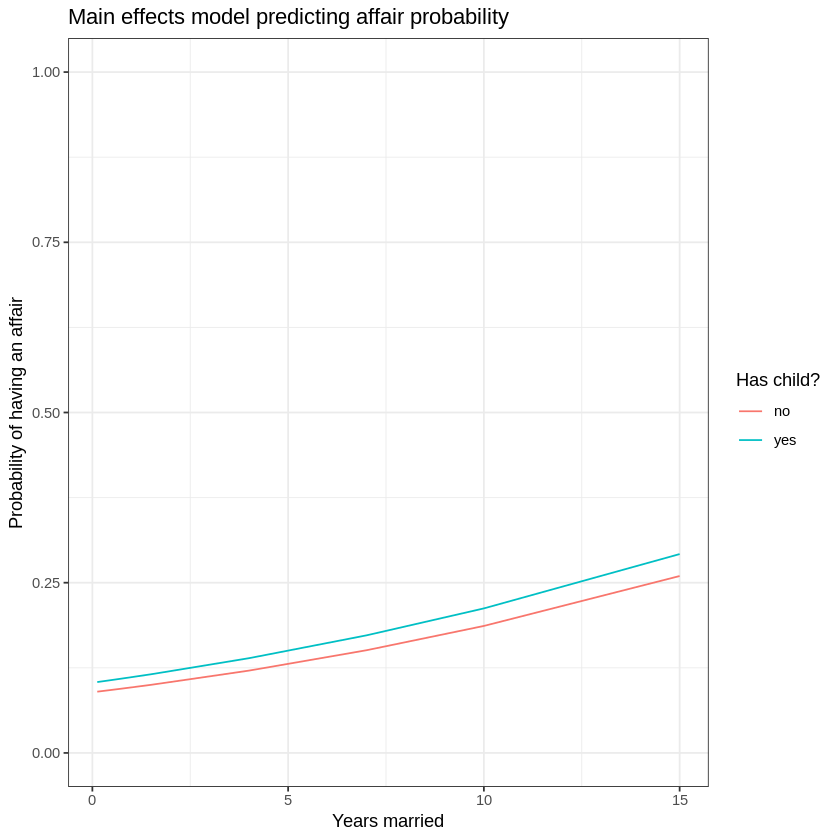

In [ ]:
## Visualize the main effects model
estimate_expectation(MainEff) %>%
  ggplot(aes(x = yearsmarried, y = Predicted, color = as.factor(children))) +
  geom_line() +
  labs(x = "Years married", y = "Probability of having an affair",
       color = "Has child?", title = "Main effects model predicting affair probability") +
  ylim(c(0, 1)) +
  theme_bw()

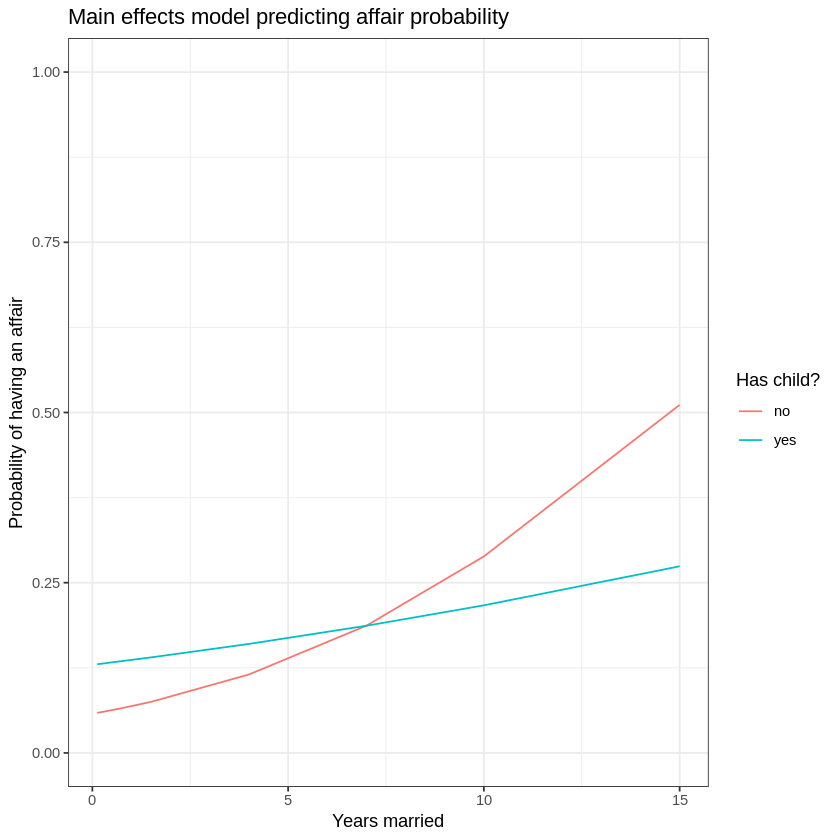

In [ ]:
## Visualize the interaction effects model
estimate_expectation(IntEff) %>%
  ggplot(aes(x = yearsmarried, y = Predicted, color = as.factor(children))) +
  geom_line() +
  labs(x = "Years married", y = "Probability of having an affair",
       color = "Has child?", title = "Main effects model predicting affair probability") +
  ylim(c(0, 1)) +
  theme_bw()

## Comparing the models

Overall, both models tend to do a bad job classifying people as having an affair or not. People are complicated after all!

Although the details are technical, we use a new test to determine model fit: the likelihood ratio test (LRT). This LRT compares whether the improved prediction by adding interaction terms (or any added model terms) is worth the added complexity for estimating more model parameters.

**Technical details note**: Logistic regression and other link functions in the general linear model family are not estimated using the ordinary least squares (i.e., sums of squared distances) approach. These models are estimated by the maximum likelihood (ML) approach. To "estimate" a model basically means to solve a very sophisticated equation with many unknown parameters (where the unknowns are the regression weights we want to know!). Least-squares approaches solve the equation by selecting parameters that minimize the sum of least squares. ML approaches use a different "equation solver" approach by selecting those terms that maximize a likelihood function. All of this to say, we can compare likelihood values across the models to see if the added likelihood values outweigh the additional complexity for estimating more terms. This is the likelihood ratio test.


In [ ]:
## Compare model performances
compare_performance(MainEff, IntEff,
                    metrics = "common") ## Ignore lots of performance indices

Name,Model,AIC,AIC_wt,BIC,BIC_wt,R2_Tjur,RMSE
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MainEff,glm,572.1511,0.2085663,585.3469,0.7038519,0.03664612,0.3877649
IntEff,glm,569.4839,0.7914337,587.0783,0.2961481,0.04248303,0.3867285


Mostly looking at the $R^2_\text{Tjur}$ values, we are not doing a good job of predicting affair status for either model. That being said, going from 0.037 to 0.042 is roughly a 13% increase ($\frac{0.042 - 0.037}{0.037} \times 100 \approx 13$). Whereas we are still doing a bad job predicting affairs overall, we appear to be doing better by adding the interaction term.  

In [ ]:
## Conduct Likelihood ratio test
test_lrt(MainEff, IntEff)

,Name,Model,df,df_diff,Chi2,p
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>
MainEff,MainEff,glm,3,NA,NA,NA
IntEff,IntEff,glm,4,1,4.667178,0.0307444


In short, the LRT test is a statistical comparison to see if adding terms (i.e., an interaction effect here) to our model improves prediction to a meaningful degree. If our p-value is below 0.05, which it is in this case, we can say that adding an interaction effect is worthwhile and improves our prediction.

Note that we will return to p-values in this course shortly. In short, small p-values mean that we are confident that our results are not due to chance occurrence and represent a meaningful statistical difference in the two models.  

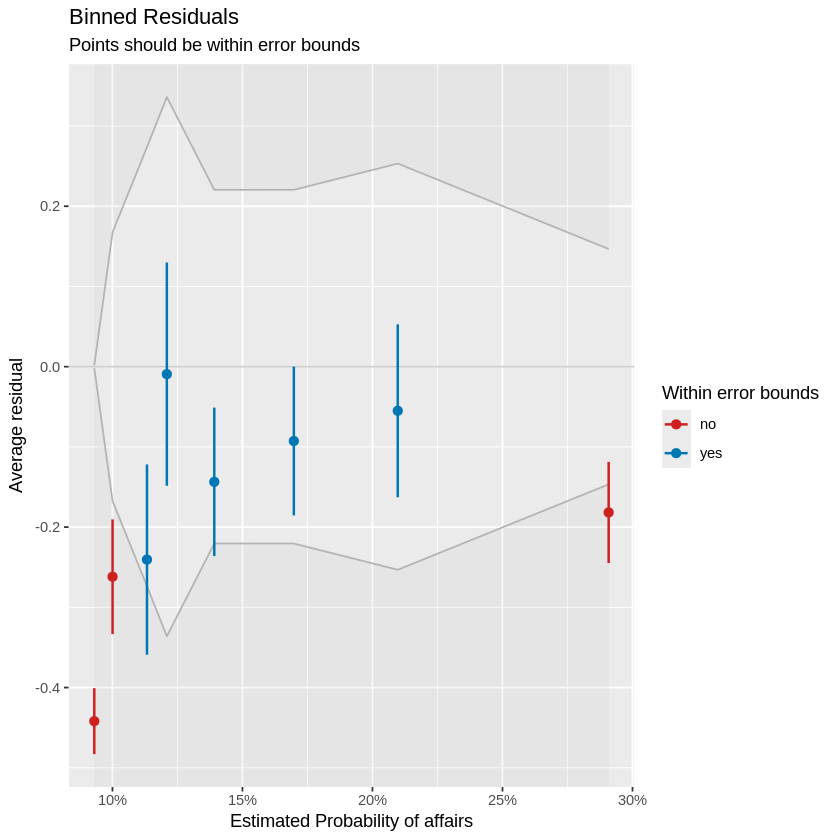

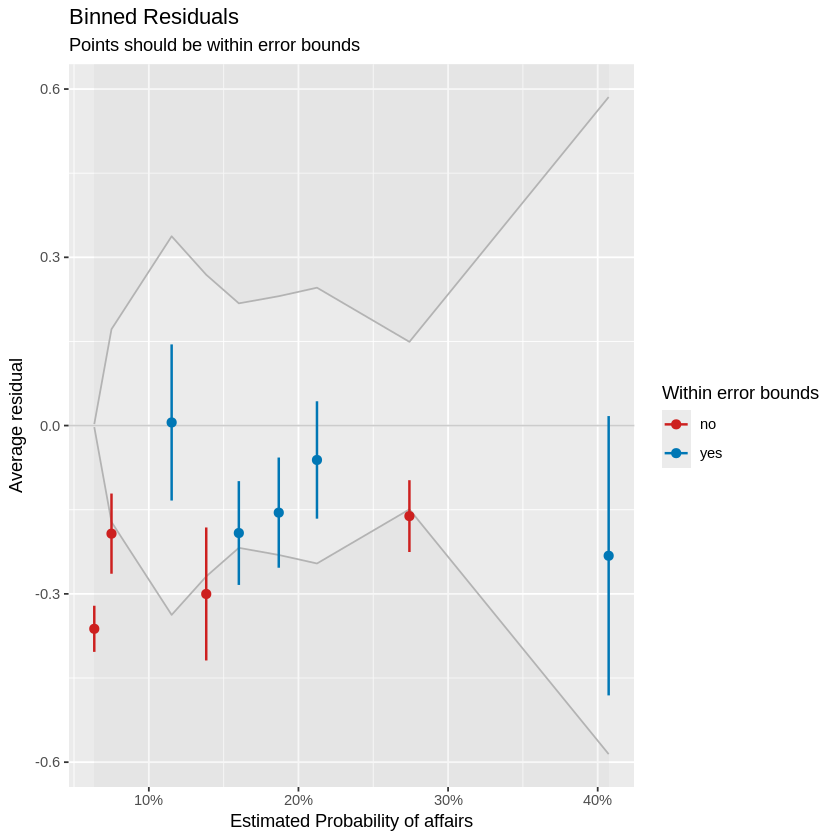

In [ ]:
## Check the binned residuals
binned_residuals(MainEff) %>% plot()
binned_residuals(IntEff) %>% plot()

According to the binned residuals, we are not doing a great job of predicting the affairs values for some cases.

# Divide-by-4 rule

In logistic regression, the Divide-By-4 rule is a quick approximation to interpret the logistic regression coefficients in terms of probability changes. It helps when dealing with log-odds (logits), which can be unintuitive.

**The idea behind the rule**

For a logistic regression coefficient ($\beta$), the exact relationship between a one-unit increase in $x$ and the probability of the outcome is the following:

$$P(1 - P)\beta$$

The maximum value of $P(1 - P)$ is 0.25, which happens when $P - 0.50$ (i.e., at the midpoint of probability). Thus, at this midpoint:

$$P(1 - P)\beta \approx 0.25 \beta $$

**How to use the Divide-By-4 rule**

- Divide the logistic regression coefficient by 4 to estimate the maximum possible change in probability for a one-unit change in $X$.

- This works best when the probability is around 50% (midpoint) but is less accurate at extreme probabilities.

**Example**

Let's examine the effect of religiousness as our example.

$logit(y) = -.42 - .34*religiousness$

Dividing the slope by four translates to a _maximum_ decrease in probability of 9%.

In [ ]:
## Model predicting affairs based on religiousness
ModRelig <- glm(affairs ~ religiousness,
                family = binomial,
                data   = AffairsClean)

## Print the parameters for ease of reading
parameters(ModRelig)

Parameter,Coefficient,SE,CI,CI_low,CI_high,z,df_error,p
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.4221267,0.27911824,0.95,-0.9755109,0.1206024,-1.512358,Inf,0.1304427750
religiousness,-0.3387924,0.09111887,0.95,-0.5197615,-0.1619456,-3.718136,Inf,0.0002006982


In [ ]:
## Divide slope by 4
(-.34 / 4) %>% round(2)

[1] -0.09

The Divide-By-4 rule shows a value of roughly -0.09. In other words, this translates to roughly a *decrease* in probability of about 9% for a 1-unit *increase* in the religiousness.

Remember, this is an approximation, let's see the percent change in probability of having an affair for every 1-unit increase in religiousness.

**Coding note**: I am first creating a data frame of "religiousness" values (i.e., 0, 1, 2, 3, 4, and 5) so that I can predict the probabilities of having an affair at each of those levels using our logistic regression model.

The next block of code uses the regression model to predict probabilities. Then, I am selecting the relevant columns. The last line of code is complicated but I am subtracting the $X - 1$ value from every $X$ term. For example, when `religiousness = 2` (i.e., $X = 2$), the predicted probability is 31.8% and the predicted probability for `religiousness = 1` was found to be 39.6%. So that means our `%Change` value for row 2 is $0.318 - 0.396 = -.077$.

In [ ]:
## Values of religiousness to predict given the model
PredictData <-
  data.frame("religiousness" = 0:5)

## Estimate the probabilities of having an affair given religiosity
estimate_expectation(model = ModRelig, data = PredictData) %>%
  select(religiousness:Predicted) %>%
  mutate("%Change" = Predicted - lag(Predicted))

[1] -0.09

,religiousness,Predicted,%Change
,<int>,<dbl>,<dbl>
1,0,0.3960080,NA
2,1,0.3184468,-0.07756120
3,2,0.2497940,-0.06865279
4,3,0.1917771,-0.05801681
5,4,0.1446373,-0.04713983
6,5,0.1075429,-0.03709442


# Continuous predictors

Let's explore some of the variables from lecture: age and happiness.

To see the interaction effects, we should view the simple slopes

In [ ]:
## The main effects of age and happiness on having an affair
MainEffHappMod <-
  glm(affairs ~ age + happiness,
      family = binomial,
      data   = AffairsClean)

## The interaction effects of age and happiness on having an affair
IntEffHappMod <-
  glm(affairs ~ age * happiness,
      family = binomial,
      data   = AffairsClean)

## Compare the fit of the models
compare_models(MainEffHappMod, IntEffHappMod)

,Parameter,Component,Effects,Log-Odds.MainEffHappMod,SE.MainEffHappMod,CI.MainEffHappMod,CI_low.MainEffHappMod,CI_high.MainEffHappMod,z.MainEffHappMod,df_error.MainEffHappMod,p.MainEffHappMod,Log-Odds.IntEffHappMod,SE.IntEffHappMod,CI.IntEffHappMod,CI_low.IntEffHappMod,CI_high.IntEffHappMod,z.IntEffHappMod,df_error.IntEffHappMod,p.IntEffHappMod
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),conditional,fixed,0.32721073,0.55977384,0.95,-0.769925827,1.4243473,0.584541,Inf,5.588564e-01,3.11136999,1.31523567,0.95,0.533555440,5.689184545,2.365637,Inf,1.799909e-02
2,age,conditional,fixed,0.01286754,0.01154897,0.95,-0.009768022,0.0355031,1.114172,Inf,2.652053e-01,-0.06670390,0.03606838,0.95,-0.137396622,0.003988814,-1.849374,Inf,6.440388e-02
3,happiness,conditional,fixed,-0.58801522,0.09347151,0.95,-0.771216010,-0.4048144,-6.290850,Inf,3.157324e-10,-1.36083434,0.34461115,0.95,-2.036259790,-0.685408888,-3.948898,Inf,7.851176e-05
4,age × happiness,conditional,fixed,NA,NA,NA,NA,NA,NA,NA,NA,0.02230284,0.00948549,0.95,0.003711621,0.040894060,2.351259,Inf,1.871003e-02


In the main effects model, age appears to have a positive effect on affair status whereas happiness has a negative effect. We can Divide-by-4 to see the approximated change in probabilities for 1-unit increases in the variables. For age, $0.013 / 4 = .003$ so a 1-year increase in age translates to a 0.3% increase in affair status. For happiness, $-0.59 / 4 = -0.15$ means roughly a 15% reduced chance of having an affair by increasing happiness from 1 point (on a 5-point scale).

In the interaction effects model, we see mostly similar values. Slightly negative effect for age and an even larger (negative) effect for happiness. The interaction is positive. In other words, as age (happiness) increases, the effect of happiness (age) actually flips.  

## Simple slopes

We can see those interaction effects in the simple slopes plots below. In the first graph, as happiness increases the effect of age shifts from strong negative to somewhat positive. In the second graph, as age increases, the effect of happiness is lessened.

For simple slopes plots, remember it doesn't *functionally* matter which variable is held constant versus allowed free to vary. The predicted scores are still the same because our data and model remain constant. However, some research questions may prefer to show one version versus another.

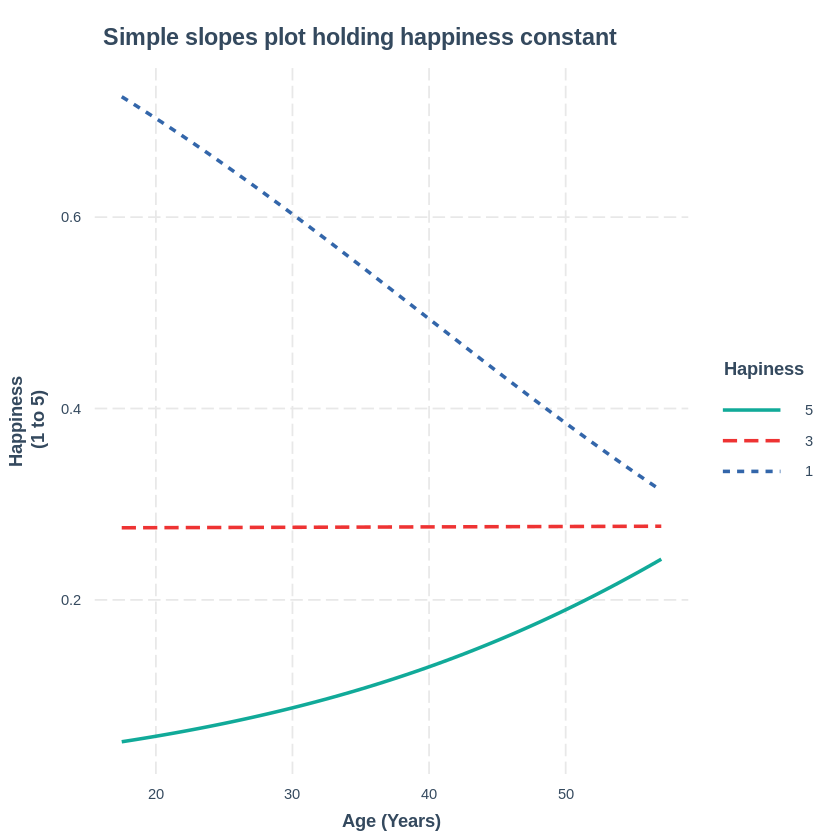

In [ ]:
## Interaction plot holding happiness constant
interact_plot(IntEffHappMod,
              pred        = "age",
              modx        = "happiness",
              modx.values = c(1, 3, 5),
              x.label     = "Age (Years)",
              y.label     = "Happiness \n(1 to 5)",
              legend.main = "Hapiness",
              colors      = "Qual1",
              main.title  = "Simple slopes plot holding happiness constant")

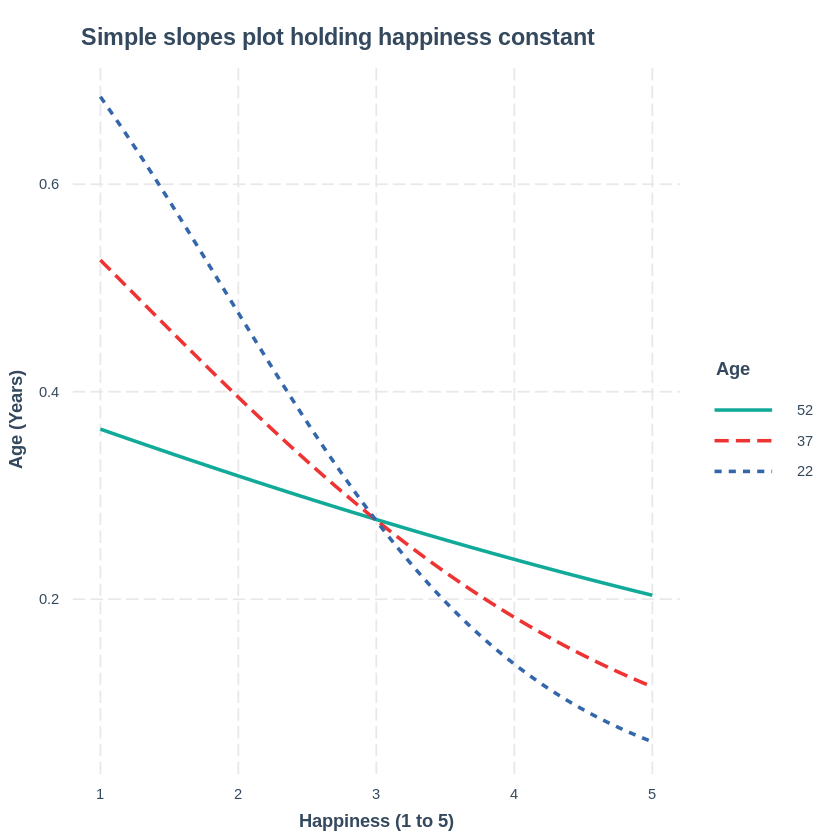

In [ ]:
## Interaction plot holding age constant
interact_plot(IntEffHappMod,
              pred        = "happiness",
              modx        = "age",
              modx.values = c(22, 37, 52),
              x.label     = "Happiness (1 to 5)",
              y.label     = "Age (Years)",
              legend.main = "Age",
              colors      = "Qual1",
              main.title  = "Simple slopes plot holding happiness constant")

## Comparing the models

For simplicity, we will compare the two models to a "null" model (i.e., one with only an intercept term). This is certainly a bad model but it gives us something to compare against.

In [ ]:
## For comparison purposes, estimate a null model
NullMod <-
  glm(affairs ~ 1,
      family = binomial,
      data   = AffairsClean)

## See how well the model does, especially with Tjur's pseudo-R^2
compare_performance(NullMod,
                    MainEffHappMod,
                    IntEffHappMod,
                    metrics = "common")

Name,Model,AIC,AIC_wt,BIC,BIC_wt,R2_Tjur,RMSE
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NullMod,glm,591.6538,8.512084e-11,596.0524,2.939028e-08,0.00000000,0.3946621
MainEffHappMod,glm,549.2087,1.402374e-01,562.4045,5.953141e-01,0.08293952,0.3783171
IntEffHappMod,glm,545.5821,8.597626e-01,563.1764,4.046859e-01,0.09167414,0.3759819


There is a small increase in predictability of affair status by adding the interaction term. The change in $R^2_\text{Tjur}$ is small (i.e., .083 to 0.92) but non-zero.

In [ ]:
## A likelihood ratio test to compare model fit
test_lrt(NullMod,
         MainEffHappMod,
         IntEffHappMod) %>%
mutate(across(c(-Name, -Model), ~ round(.x, 4))) ## Round numeric columns to 4

,Name,Model,df,df_diff,Chi2,p
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NullMod,NullMod,glm,1,NA,NA,NA
MainEffHappMod,MainEffHappMod,glm,3,2,46.4451,0.0000
IntEffHappMod,IntEffHappMod,glm,4,1,5.6266,0.0177


The Likelihood Ratio Test (LRT) has a statistically significant difference (p-value of 0.018 < 0.05). That means our interaction effect represents a worthwhile contribution to predicting affair status in our model.

,xbar,ybar,n,x.lo,x.hi,se,CI_low,CI_high,group
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
conf_int,0.06196937,-0.28264188,73,0.05172901,0.06256302,0.1037932,-0.32871879,-0.236564959,no
conf_int1,0.07706400,-0.05666778,62,0.07706400,0.07706400,0.2241644,-0.14722685,0.033891282,yes
conf_int2,0.09458691,-0.21311953,45,0.09458691,0.09458691,0.2201017,-0.30684892,-0.119390141,yes
conf_int3,0.11559517,-0.22482010,19,0.11559517,0.11559517,0.3647850,-0.38400235,-0.065637848,yes
conf_int4,0.13701652,-0.18057090,28,0.12585818,0.13742980,0.3346044,-0.32372942,-0.037412382,yes
conf_int5,0.14920236,-0.27967939,61,0.14054518,0.15132249,0.2025348,-0.36710287,-0.192255919,no
conf_int6,0.16634874,0.03709610,39,0.16634874,0.16634874,0.3466993,-0.10835244,0.182544642,yes
conf_int7,0.17994102,-0.05699326,39,0.16984618,0.18254614,0.3326261,-0.19795556,0.083969037,yes
conf_int8,0.19994243,-0.13267374,23,0.19994243,0.19994243,0.4243825,-0.31388740,0.048539921,yes


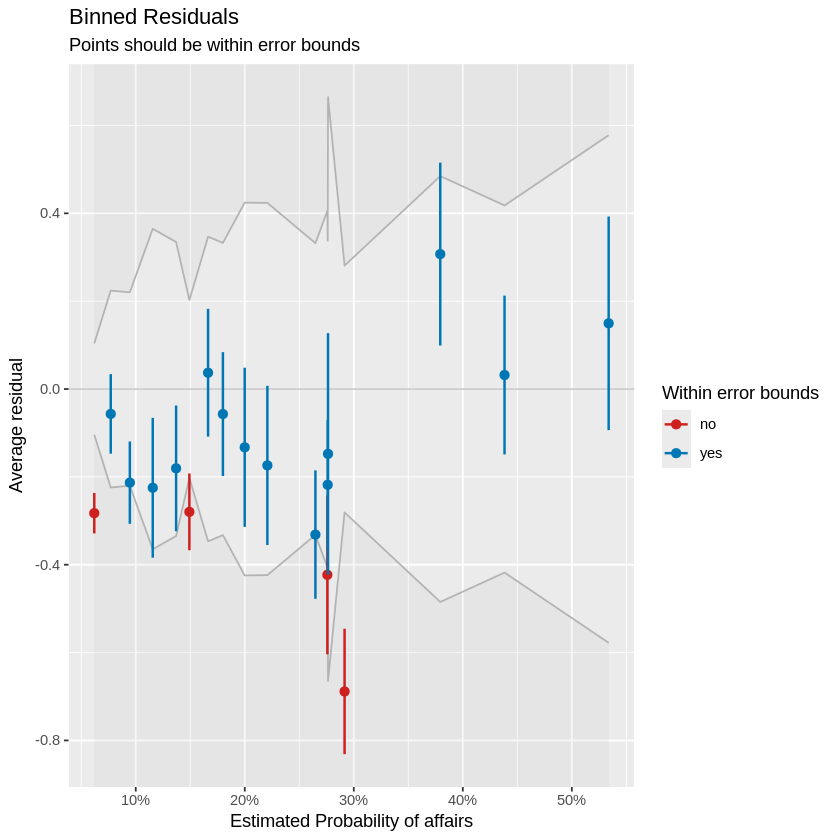

In [ ]:
## Check the binned residuals
binned_residuals(IntEffHappMod)
binned_residuals(IntEffHappMod) %>% plot()